# GPGN409 homework 
your name: Benjamin Nguyen

In [462]:
using DataFrames, CSV
using LinearAlgebra
using Plots, Printf

## Gaussian function
In mathematics, a Gaussian function [Wikikipedia], often simply referred to as a Gaussian, is a function of the base form

$$f(x) = \exp(-x^2)$$

and with parametric extension

$$f(x) = a \exp\left( -\frac{(x - b)^2}{2c^2} \right)$$

for arbitrary real constants $a$, $b$, and non-zero $c$. It is named after the mathematician Carl Friedrich Gauss. The graph of a Gaussian is a characteristic symmetric "bell curve" shape. The parameter $a$ is the height of the curve's peak, $b$ is the position of the center of the peak, and $c$ (the standard deviation, sometimes called the Gaussian RMS width) controls the width of the "bell".

Now, we need to find: $a$, $b$, and non-zero $c$

## Linearization

The Gaussian function is given by:

$$
f(x) = a \exp \left( -\frac{(x - b)^2}{2c^2} \right)
$$


$$
\therefore f(x) = a \exp \left( -\frac{x^2 - 2bx + b^2}{2c^2} \right)
$$

This simplifies to:

$$
f(x) = a \exp \left( -\frac{x^2}{2c^2} + \frac{bx}{c^2} - \frac{b^2}{2c^2} \right)
$$

Taking the natural logarithm of both sides for linearization:

$$
\ln(f(x)) = \ln(a) - \frac{x^2}{2c^2} + \frac{bx}{c^2} - \frac{b^2}{2c^2}
$$
    
Or
$$
\ln(f(x)) = \ln(a) - \frac{b^2}{2c^2} + \frac{bx}{c^2} - \frac{x^2}{2c^2}
$$

Let $ m = \ln(a) - \frac{b^2}{2c^2} $, $ n = \frac{b}{c^2} $, and $ p = -\frac{1}{2c^2} $.

The equation becomes:

$$
\ln(f(x)) = m + n x + p x^2
$$



## Forward Problem

This can be rewritten in matrix form as:

$$
d = 
\begin{bmatrix} 
1 & x & x^2 
\end{bmatrix}
\begin{bmatrix} 
m \\ 
n \\ 
p 
\end{bmatrix}
$$

Model parameter

- $m = \ln(a) - \frac{b^2}{2c^2}$
- $n = \frac{b}{c^2}$
- $p = -\frac{1}{2c^2}$

Data (with $d = P$)
- $d = \ln(f(x))$

Operator (with $x = t$)
- $\begin{bmatrix} 
1 & x & x^2 
\end{bmatrix}$



## Least Squares

In the standard least squares method, we aim to minimize the residuals between the observed data and the predicted data. The residuals are defined as:

$$
\mathbf{r} = \|\mathbf{d} - G \cdot \mathbf{m}\|
$$

where:
- $\mathbf{d}$ is the vector of observed data.
- $G$ is the matrix operator (forward operator).
- $\mathbf{m}$ is the vector of model parameters.



The solution:

$$
\mathbf{m} = (G^T  G)^{-1} G^T  \mathbf{d}
$$


## Calculate the model parameters

In [463]:
# Load the data from the text file
df = CSV.read("HW4data.csv", DataFrame; delim=',', ignorerepeated=true)

# Plot data
t = df.Year # Time axis
P = df.KBPY # Number of berrels per year

# Calculate model parameters m, n, p
N = length(t) # Length of the data
G = hcat(ones(length(x_data)), x_data, x_data.^2) # Create the forward operator
d = log.(P) # Natural Logarithm because of the linearization
M = (G'G)^-1*G'd # P = d
print("Model parameters: ")
@show m, n, p = M; # Display the parameters

Model parameters: (m, n, p) = M = [-2313.0313608422875, 2.3559875662613194, -0.000596082201031578]


In [464]:
# Calculate parameters: a, b, c
c_squared = -1 / (2 * p)
c = √(c_squared)
# Calculate b from n
b = n * c_squared
# Calculate a from m
a = exp(m + (b^2) / (2 * c_squared));

@show a, b, c;

(a, b, c) = (3.1153269051012946e6, 1976.227072527962, 28.9622251347011)


The optimal Gaussian that ﬁts the observation:
$$f(x) = a \exp\left( -\frac{(x - b)^2}{2c^2} \right)$$

with above $a=3.1153269051012946e6$, $b=1976.227072527962$, $c=28.9622251347011$

## Plot and compare the inversion data with the real data

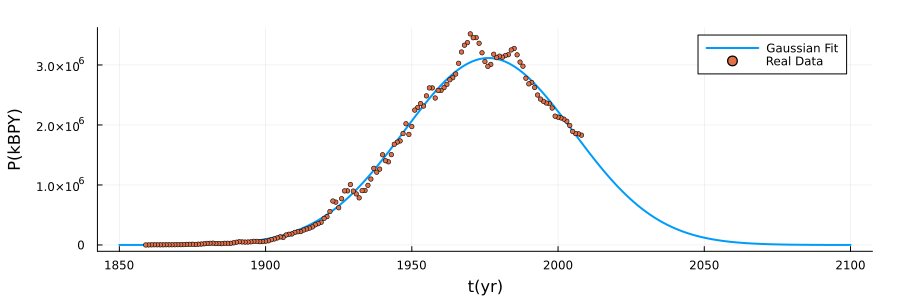

In [470]:
t0 = 1850
t1 = 2100
time = t0:t1
nbarrels = a .* exp.(-((time .- b).^2) ./ (2 * c^2))
plot(time, nbarrels, linewidth=2, label="Gaussian Fit")
scatter!(t, P, size=(900, 300), markersize=2.5, label="Real Data")
# xlims!(1850, 2100)
xlabel!("t(yr)")
ylabel!("P(kBPY)")
plot!(legend=:topright, margin=5Plots.mm)

##  Cummulative oil production until year 2100
The cummulative oil production from year $t_0$ to year $t$:

$$C(t) = \int_{t_0}^{t} a \cdot \exp\left( -\frac{(t' - b)^2}{2c^2} \right) \, dt'$$

Lets use the trapezoidal rule

The formula for the trapezoidal rule is:

$$
\int_{a}^{b} f(x) \, dx \approx \frac{\Delta x}{2} \left( f(x_0) + 2 \sum_{i=1}^{n-1} f(x_i) + f(x_n) \right)
$$

Where, $a$ and $b$ are the bounds of the integral, $x_0, x_1, \dots, x_n$ are the points where the function is evaluated, $\Delta x = \frac{b - a}{n}$ is the width of each subinterval.

In [466]:
# Trapezoidal rule for numerical integration
function gaussian(t, a, b, c)
    return a * exp.(-((t .- b).^2) ./ (2 * c^2))
end

function trapezoidal_rule(f, t0, t1, a, b, c, n)
    h = (t1 - t0) / n
    t_values = range(t0, stop=t1, length=n+1)
    f_values = f(t_values, a, b, c)
    
    integral = h * (0.5 * f_values[1] + sum(f_values[2:end-1]) + 0.5 * f_values[end])
    return integral
end
n = 1000
# Compute the cumulative oil production using the trapezoidal rule
cumulative_oil = trapezoidal_rule(gaussian, t0, t1, a, b, c, n)

# Display the result
@printf("Cumulative oil production from 1850 to 2100: %.2e barrels\n", cumulative_oil)


Cumulative oil production from 1850 to 2100: 2.26e+08 barrels


In [469]:
# 1 ton of CO2 is equivalent with 3.15 barrels of oil.
co2 = @printf("Cumulative emitted CO2 from 1850 to 2100: %.2e ton\n", cumulative_oil/3.15)

Cumulative emitted CO2 from 1850 to 2100: 7.18e+07 ton


The equation for the logistic curve is given by:

$$
Q = \frac{L}{1 + e^{-k(t - t_0)}}
$$

Take the reciprocal of both sides:
$$
\frac{1}{Q} = \frac{1 + e^{-k(t - t_0)}}{L}
$$




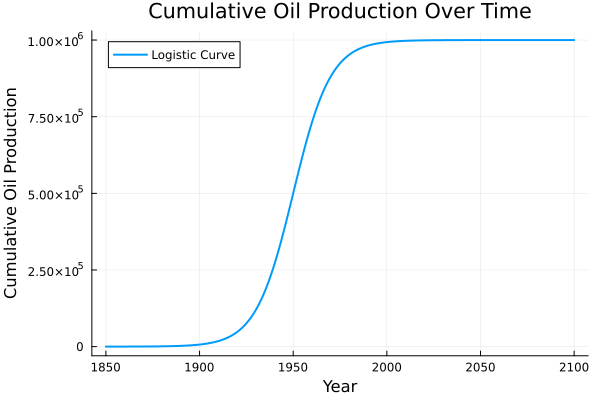

In [471]:
using Plots

# Define the logistic function
function logistic_curve(t, L, k, t0)
    return L ./ (1 .+ exp.(-k * (t .- t0)))
end

# Parameters for the logistic curve
L = 1_000_000  # Example total production
k = 0.1        # Growth rate
t0 = 1950      # Midpoint year

# Define the time range
t = 1850:2100

# Calculate Q for each time value
Q = logistic_curve(t, L, k, t0)

# Plot the logistic curve
plot(t, Q, label="Logistic Curve", xlabel="Year", ylabel="Cumulative Oil Production", lw=2)
title!("Cumulative Oil Production Over Time")
